# Présentation POC framework covid19

La librairie covid19 a pour objet de favoriser les échanges au sein de l'APHP sur la recherche et les études sur le covid19. Afin de favoriser ceux-ci, l'équipe datascience envisage de développer certaines fonctionnalités pour aider les aspects suivants : 
- communication / transparence
    - aider à expliciter les traitements envers des non-data scientistes
    - détailler le fonctionnement de la librairie
- reproductibilité
    - permettre de sauvegarder les interfaces (SQL, fichiers)
- fonctionnement "open"
    - être capable de customiser le fonctionnement de la librairie

# Import

In [1]:
import pandas as pd
import numpy as np

import os, sys
# Adding parent directory to python path
sys.path.append(os.path.dirname(os.getcwd()))

import ml_workflow
from ml_workflow import Rule, DataSource

import sqlite3

# Pseudo covid 19

Le code suivant représente des examples (extrêmement simplifiés) de comportements attendus de la librairie covid19.
Les fonctionnalités présentées ici sont à l'état de POC et attendent vos retours pour être intégrés dans la librairie covid19.

In [2]:
personnal_data_file = 'data/train.csv'
pcr_tests_db = 'data/pcr_tests.db'
consultation_db = 'data/consultations.db'


@DataSource(name='Personnal data csv file')
def retrieve_personnal_data():
    return pd.read_csv(personnal_data_file)

@DataSource(name='Retrieve pcr tests')
def retrieve_pcr_tests():
    conn = sqlite3.connect(pcr_tests_db)
    return pd.read_sql(
        'SELECT id, person_id, pcr_result, test_date FROM pcr_test ORDER BY id',
        conn
    )

@DataSource(name='Retrieve data source')
def retrieve_visites():
    conn = sqlite3.connect(consultation_db)
    return pd.read_sql(
        'SELECT id, person_id, services, hospital, consultation_date FROM consultations ORDER BY id',
        conn
    )

@Rule(name='select_with_age', highlight=2)
def select_with_age(personnal_df):
    return personnal_df[np.logical_not(personnal_df['age'].isna())]
        
def get_patients_status():
    personnal_df = retrieve_personnal_data()
    personnal_df = Rule.call_from_reference_name('select_with_age')(personnal_df)
        
    return personnal_df

def get_patients_pcr_positives():
    patient_status = get_patients_status()
    
    tests_pcr = retrieve_pcr_tests()
    
    with Rule(name='pcr positif'):
        tests_pcr = tests_pcr[tests_pcr['pcr_result'] == 'positive']
    
    with Rule(name='pcr_positif_merge'):
        return patient_status.merge(tests_pcr, left_on='id', right_on='person_id')
    
def get_consultations():
    return retrieve_visites()


## Sqlite3 play-ground

In [3]:
# conn = sqlite3.connect(pcr_tests_db)
# conn.execute("UPDATE pcr_test SET pcr_result = 'positive' WHERE pcr_result = 'Positif'")
# conn.commit()

## Pandas play-ground

In [4]:
get_patients_status()['age'].mean()

29.6206862745098

# User code

**Exemple n 1** : On récupère une sortie de la librairie covid19, et l'on souhaite avoir le détail de son origine.

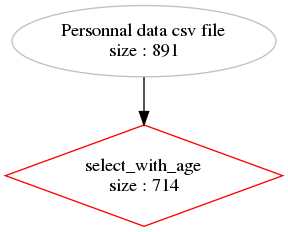

In [5]:
patient_status = get_patients_status()

patient_status.plot_model()

**Exemple n 2** : La même chose sur un exemple un peu plus compliqué

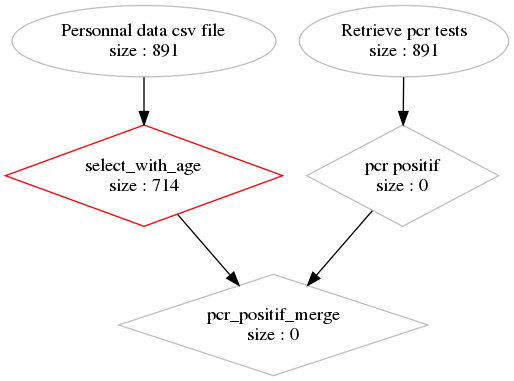

In [6]:
get_patients_pcr_positives().plot_model()

Le système ci-dessus permet d'assurer la transparence de la librairie covid19 en exposant les traitements interne, l'origine des données ...

La librairie permet aussi de tracer les traitements de l'utilisateur.
A noter que le format svg, si il n'est pas intégrable directement dans jupyter, permet potentiellement, via des fichiers générés / liens, d'ajouter beaucoup d'information sur l'étape concernés.
Par exemple :
    - la requête SQL exécuté
    - le code source
    - la documentation
Etc ...

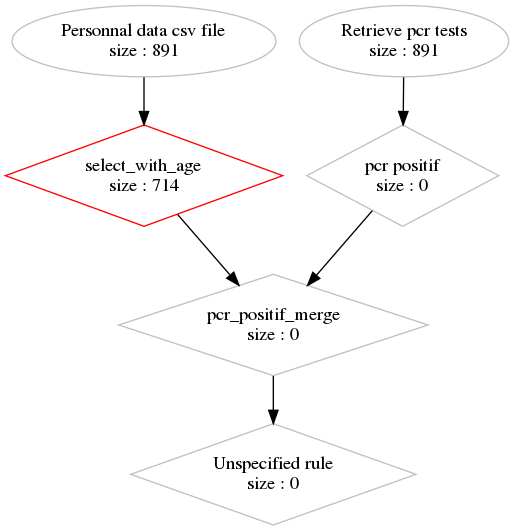

In [7]:
patients = get_patients_pcr_positives()

my_patient_status = patients[patients['age'] >= 18]
my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.svg')
my_patient_status.plot_model()


Le principe de ce framework étant de traquer toutes les étapes du traitement, ceux de l'utilisateur sont également indiqués dans le graph. Pour leur donner un nom, il faut les exécuter au sein d'une règle.

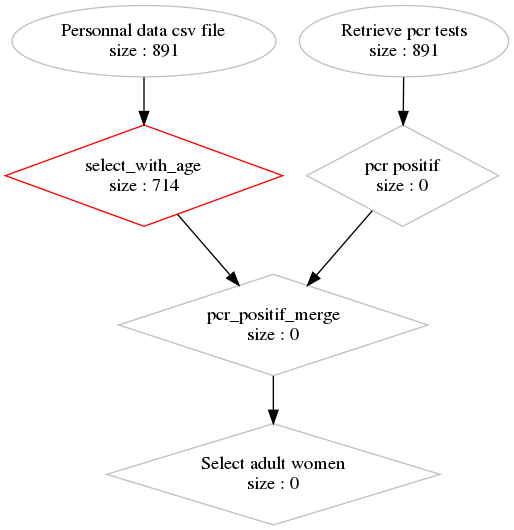

In [8]:
patients = get_patients_pcr_positives()

with Rule(name='Select adult women'):
    my_patient_status = patients[patients['age'] >= 18]
    my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.png')

## Vérification de contraintes

A noter qu'il est possible d'utiliser ce framework pour vérifier des contraintes d'ordonnancement sur des traitements (des traitements doivent être effectués avant/après d'autre) 

In [9]:
def check_is_called_after(node, rule_name):
    if node.origin.name == rule_name:
        return True
    
    for parent in node.parents:
        if check_is_called_after(parent, rule_name):
            return True
        
    return False

def check_is_called_after_rule(leaf_node, rule_1, rule_2):
    if isinstance(leaf_node, pd.DataFrame):
        return check_is_called_after_rule(leaf_node.ml_workflow_node, rule_1, rule_2)
    
    result = True
    for node in leaf_node.get_all_nodes():
        if node.origin.name == rule_1:
            result = result and check_is_called_after(node, rule_2)
            
    return result

print(check_is_called_after_rule(my_patient_status, 'select_with_age', 'Personnal data csv file'))
print(check_is_called_after_rule(my_patient_status, 'select_with_age', 'Retrieve pcr tests'))

True
False


# Fonctionnalité reproductibilité

Une petite query pour éviter les effets de bord de cellules préalable

In [10]:
conn = sqlite3.connect(pcr_tests_db)
conn.execute("UPDATE pcr_test SET pcr_result = 'positive' WHERE pcr_result = 'Positif'")
conn.commit()

Supposons que l'on fasse une étude sur des patients à pcr positifs

Nb patients : 327


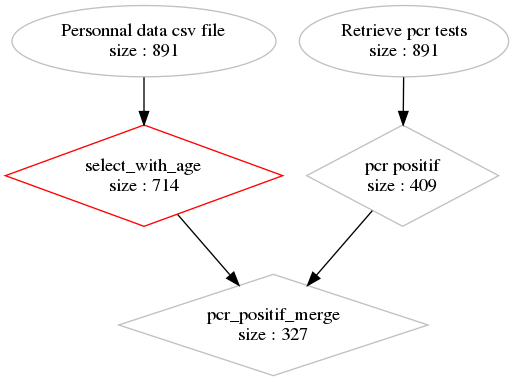

In [11]:
from ml_workflow.session import Session   
    
with Session.record_data_source('temp/test_session_record'):
    patients = get_patients_pcr_positives()

print(f"Nb patients : {len(patients)}")
patients.plot_model('graph.png')

Mais que la convention de la base de donnée change, remplaçant 'positive' par 'Positif'

In [12]:
conn = sqlite3.connect(pcr_tests_db)
conn.execute("UPDATE pcr_test SET pcr_result = 'Positif' WHERE pcr_result = 'positive'")
conn.commit()

Rendant le traitement des données inefficace

Nb patients : 0


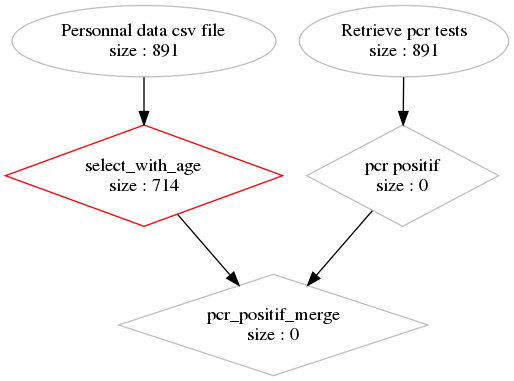

In [13]:
patients = get_patients_pcr_positives()
print(f"Nb patients : {len(patients)}")

patients.plot_model('graph.png')

Le fait d'avoir "freezé" la session permet de retrouver son résultat.

Nb patients : 327


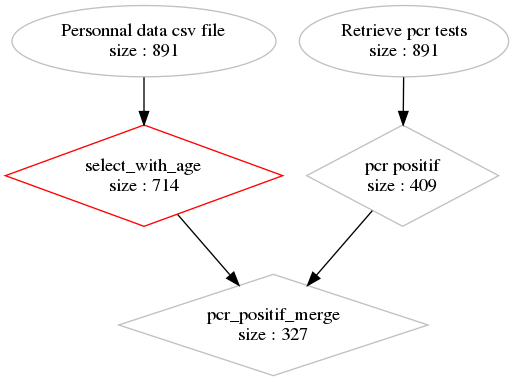

In [14]:
with Session.play_data_source_record('temp/test_session_record'):
    patients = get_patients_pcr_positives()
    
print(f"Nb patients : {len(patients)}")
patients.plot_model()

## Cleaning db for the other cells

In [15]:
conn = sqlite3.connect(pcr_tests_db)
conn.execute("UPDATE pcr_test SET pcr_result = 'positive' WHERE pcr_result = 'Positif'")
conn.commit()

# Fonctionnalité versionning

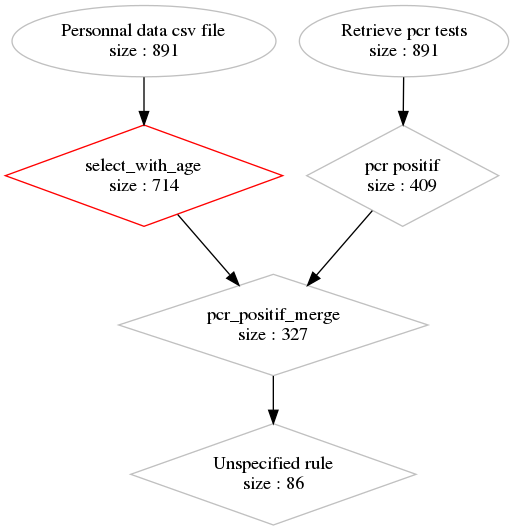

In [16]:
patients = get_patients_pcr_positives()

my_patient_status = patients[patients['age'] >= 18]
my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.png')

# Fonctionnalité de choix de version de règles

On peut également choisir d'overrider une règle avec une règle custom.
Ici disons que plutôt que de ne sélectionner que les personnes avec un age défini 

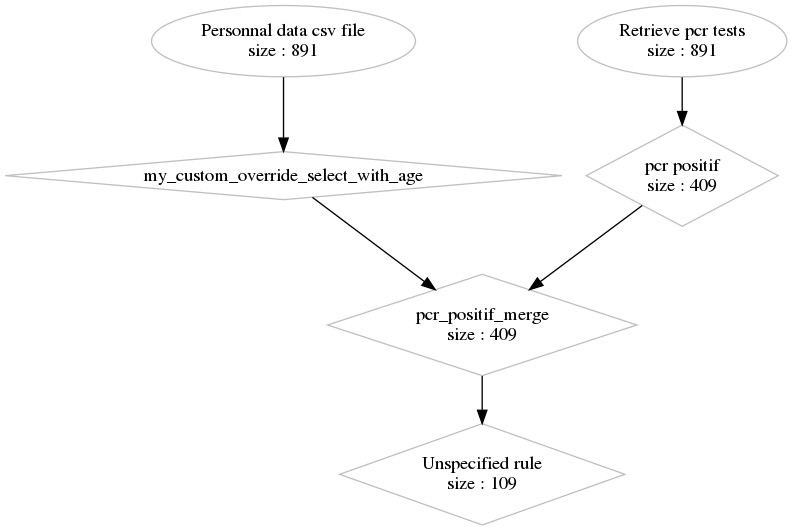

In [17]:
@Rule(name='my_custom_override_select_with_age')
def my_custom_override_select_with_age(df):
    df.loc[df['age'].isna(), 'age'] = df['age'].mean()
    
    return df

Rule.set_for_reference_name('select_with_age', my_custom_override_select_with_age)

patients = get_patients_pcr_positives()

my_patient_status = patients[patients['age'] >= 18]
my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.png')

In [18]:
Rule.unset_for_reference_name('select_with_age')